<a href = "https://www.pieriantraining.com"><img src="../PT Centered Purple.png"> </a>

<em style="text-align:center">Copyrighted by Pierian Training</em>

# Image Generation Exercise

## GOAL: Given a list of ingredients, generate a dish, a recipe, and a picture of the dish

In [1]:
# Here are your ingredients, but feel free to change them!

ingredients = ["flour", "eggs", "milk", "sugar", "butter", "salt", "onions", "garlic", "tomatoes", "cheese"]


---

### TASK: Connect to Bedrock Runtime via Boto3

In [2]:
import boto3
import json
bedrock_runtime = boto3.client(aws_access_key_id="",
                               aws_secret_access_key="",
                               region_name="us-east-1",
                               service_name='bedrock-runtime')


### TASK: Create a prompt that will take the ingredients list and generate a dish and recipe

In [3]:
def create_dish_prompt(list_of_ingredients):
    prompt = f"Create a detailed recipe based on only the following ingredients: {', '.join(ingredients)}.\n" \
             + f"Additionally, assign a title starting with 'Recipe Title: ' to this dish."
    return prompt


### TASK: Use the LLM to Generate the Dish and Recipe

In [4]:
dish_prompt = create_dish_prompt(ingredients)

In [5]:
print(dish_prompt)

Create a detailed recipe based on only the following ingredients: flour, eggs, milk, sugar, butter, salt, onions, garlic, tomatoes, cheese.
Additionally, assign a title starting with 'Recipe Title: ' to this dish.


In [6]:
llm_body = json.dumps({
    "inputText": dish_prompt,
    "textGenerationConfig": {
        "temperature": 0.5,
        "maxTokenCount": 512

    }
})


In [7]:
response = bedrock_runtime.invoke_model(body=llm_body, modelId="amazon.titan-text-express-v1")
response_body = json.loads(response.get('body').read())
response_body

{'inputTextTokenCount': 48,
 'results': [{'tokenCount': 512,
   'outputText': '\nRecipe Title: Creamy Tomato Pasta\n\nIngredients:\n* 2 cups all-purpose flour\n* 4 large eggs\n* 2 cups whole milk\n* ½ cup granulated sugar\n* ½ cup unsalted butter, softened\n* ¼ teaspoon salt\n* 1 medium onion, finely chopped\n* 3 cloves garlic, minced\n* 2 cans (28 ounces each) crushed tomatoes\n* ½ cup grated Parmesan cheese\n* Freshly ground black pepper\n* Fresh basil leaves, chopped, for garnish\n\nInstructions:\n1. Preheat the oven to 375°F (190°C).\n2. In a large bowl, whisk together the flour and salt. Create a well in the center and crack the eggs into the well. Whisk the eggs until they are well combined with the flour.\n3. Gradually add the milk to the egg mixture, whisking continuously until the mixture is smooth and creamy.\n4. Melt the butter in a large saucepan over medium heat. Add the onion and garlic to the saucepan and cook until the onion is softened, about 5 minutes.\n5. Add the cru

**Extract the title**

In [8]:
import re
def extract_title(recipe):
    return re.findall("^.*Recipe Title: .*$", recipe, re.MULTILINE)[0].strip().split("Recipe Title: ")[1]


In [9]:
content = response_body["results"][0]["outputText"]

In [10]:
recipe_title = extract_title(content)

### TASK: Use Titan Image Generation via Boto3 to generate an Image of the dish

In [11]:
import base64
from PIL import Image

In [12]:
prompt = f"'{recipe_title}', professional food photography, 15mm, studio lighting"


In [13]:
request_body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt,       
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,  
            "quality": "premium",  # standard or premium
            "height": 512,       
            "width": 512,
            "cfgScale": 8,
            "seed": 0             
        }
    }
)
response = bedrock_runtime.invoke_model(body=request_body, modelId="amazon.titan-image-generator-v1")
response_body = json.loads(response.get('body').read())

In [14]:
base64_image_data = base64.b64decode(response_body["images"][0])

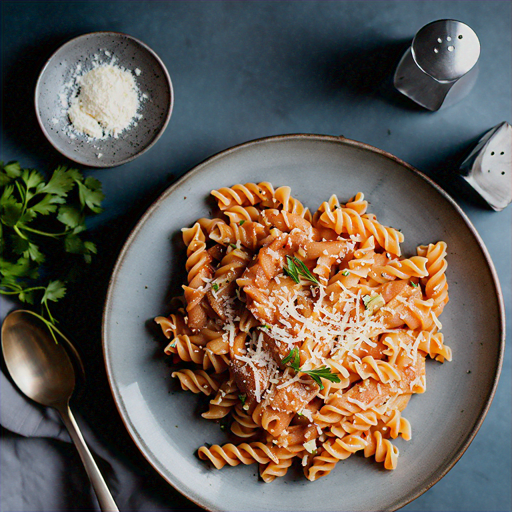

In [15]:
file_path = "dish.png"
with open(file_path, "wb") as file:
    file.write(base64_image_data)
Image.open("dish.png")

### TASK: Use Titan Image Generation to Restyle the image to be in the style of a Watercolor Painting

In [16]:
with open("dish.png", "rb") as f:
    content = f.read()
    image_string = base64.b64encode(content).decode("utf-8")


In [17]:
request_body_variation = json.dumps({
         "taskType": "IMAGE_VARIATION",
         "imageVariationParams": {
             "text": "Watercolor Painting",
             "images": [image_string],  # Use the original image string, not the base64 bytes data!
         },
         "imageGenerationConfig": {
             "numberOfImages": 1,
             "quality": "premium",
             "height": 512,
             "width": 512,
             "cfgScale": 9
         }
     }
)


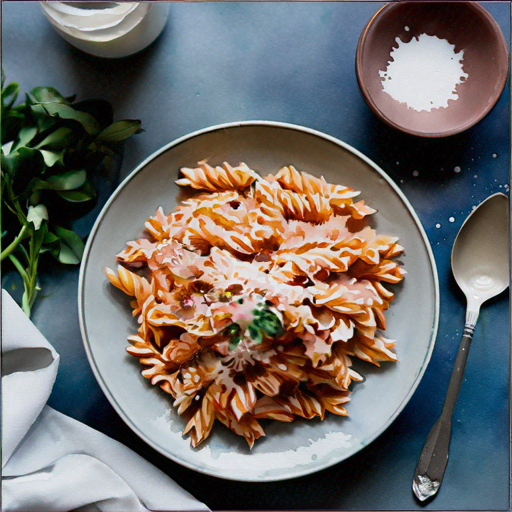

In [18]:
response_variation = bedrock_runtime.invoke_model(body=request_body_variation, modelId="amazon.titan-image-generator-v1")
response_variation_body = json.loads(response_variation.get('body').read())
base64_image_data_variation = base64.b64decode(response_variation_body["images"][0])

file_path = "dish_2.png"
with open(file_path, "wb") as file:
    file.write(base64_image_data_variation)
Image.open("dish_2.png")
